In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #data visualization
import seaborn as sns
from sklearn.model_selection import train_test_split # Split data to train and test data(after merging in this case)
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix 
import warnings
warnings.filterwarnings('ignore')


# import libraries from tensorflow
from tensorflow import keras
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import HeUniform

In [2]:
pd.set_option('display.max_rows', None)
df = pd.read_excel("AmidationDataset_29July_CuratedDataset1.xlsx")
df = df.drop(['References'], axis=1)


In [3]:
#Data Imputation
from sklearn.impute import SimpleImputer

# Columns with missing values
missing_columns = ['Activator (equiv.)', 'Time (h)']

# 1. Imputation for numerical features (using mean or median)
numerical_columns = ['Acid (equiv.)', 'Amine (equiv.)', 'Activator (equiv.)', 'Base (equiv.)', 
                     'Global Conc (M)', 'Temp (C)', 'Time (h)']

# Create a SimpleImputer for numerical columns (using 'mean' strategy)
imputer_num = SimpleImputer(strategy='mean')

# Apply the imputer to numerical columns
df[numerical_columns] = imputer_num.fit_transform(df[numerical_columns])

In [4]:
X_train = df.drop(columns=['Reaction_Yield'])
y_train = df['Reaction_Yield']

In [5]:
df_test = pd.read_excel("CHEM-testDATASET.xlsx")
df_test.drop('References',axis=1,inplace=True)
# Splitting the test dataset into features (X) and target variable (y)
X_test = df_test.drop(columns=['Reaction_Yield'])
y_test = df_test['Reaction_Yield']

In [6]:
X_test.shape

(20, 12)

## Categorical Encoding fitted on X_train, used(transformed) on test data

In [7]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# List of categorical columns
categorical_columns = ['Acid (name)', 'Amine (name)', 'Activator (name)', 'Base (name)', 'Solvent']

# Initialize a dictionary to store the label encoders for each column
label_encoders = {}

# Apply label encoding to each categorical column in both train and test data
for col in categorical_columns:
    label_encoder = LabelEncoder()
    
    # Fit the label encoder on the training data
    X_train[col] = label_encoder.fit_transform(X_train[col])
    
    # Store the label encoder for later use
    label_encoders[col] = label_encoder
    
    # For the test data, handle unseen labels by converting them to a new category
    unseen_mask = ~X_test[col].isin(label_encoder.classes_)
    X_test.loc[unseen_mask, col] = 'Unknown'  # or assign another placeholder category
    
    # Add 'Unknown' to the label encoder classes
    label_encoder.classes_ = np.append(label_encoder.classes_, 'Unknown')
    
    # Transform the test data
    X_test[col] = label_encoder.transform(X_test[col])



## Loading all Pickled Models

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, r2_score

# Load the model from the saved file
#with open('label_encoder_rlgb_172TrD_80R2.pkl', 'rb') as f:
#    label_encoders = pickle.load(f)

# Load the model from the saved file
with open('rlgb_optuna.pkl', 'rb') as f:
    loaded_regressor = pickle.load(f)
    
# Load the model from the saved file
with open('encoder_rlgb_optuna.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

## Categorical Encoding of Test Data

In [8]:
# # List of categorical columns
# categorical_columns = ['Acid (name)', 'Amine (name)', 'Activator (name)', 'Base (name)', 'Solvent']

# # Apply label encoding to each categorical column in both train and test data
# for col in categorical_columns:
    
#     label_encoder = label_encoders[col]  # Retrieve the encoder for the current column
    
#     # For the test data, handle unseen labels by converting them to a new category
#     unseen_mask = ~X_test[col].isin(label_encoder.classes_)
#     X_test.loc[unseen_mask, col] = 'Unknown'  # or assign another placeholder category
    
#     # Add 'Unknown' to the label encoder classes
#     label_encoder.classes_ = np.append(label_encoder.classes_, 'Unknown')
    
#     # Transform the test data
#     X_test[col] = label_encoder.transform(X_test[col])



In [27]:
# # Load the label encoders
# # with open('label_encoders.pkl', 'rb') as f:
# #     label_encoders = pickle.load(f)

# # Apply the stored label encoders to the new test data
# for col in categorical_columns:
#     label_encoder = label_encoders[col]
    
#     # Handle unseen labels in the new test data by assigning them to 'Unknown'
#     unseen_mask = ~X_test[col].isin(label_encoder.classes_)
#     X_test.loc[unseen_mask, col] = 'Unknown'
    
#     # Transform the test data using the stored label encoder
#     X_test[col] = label_encoder.transform(X_test[col])


## Model Testing on New data

In [9]:
#Extract learned representations from the encoder
X_test_encoded = loaded_encoder.predict(X_test)

# Use the loaded model to predict on X_test_encoded
y_pred_loaded = loaded_regressor.predict(X_test_encoded)

# Evaluate the predictions
mse_loaded = mean_squared_error(y_test, y_pred_loaded)
rmse_loaded = mse_loaded ** 0.5
r2_loaded = r2_score(y_test, y_pred_loaded)

print(f"Loaded Model MSE: {mse_loaded}")
print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model R-squared: {r2_loaded}")

1/1 [==============================] - 0s 84ms/step
Loaded Model MSE: 30.395400828266112
Loaded Model RMSE: 5.513202411327387
Loaded Model R-squared: 0.8000927287310471


In [15]:
#Recompute MSE on normalised/scaled ground truth and prediction

import math

from sklearn.preprocessing import MinMaxScaler
# Create the scaler and fit it on the actual Zoom values
scaler = MinMaxScaler()
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))

# Predict with your model
#y_pred = best_model.predict(X_test)

# Normalize predictions - Ensure predictions are reshaped for scaler compatibility if needed
y_pred_scaled = scaler.transform(y_pred_loaded.reshape(-1, 1))
# Compute MSE on the normalized scale
mse_normalized = mean_squared_error(y_test_scaled, y_pred_scaled)
print("Mean Squared Error on Normalized Scale for Focus: ", mse_normalized)

rmse = math.sqrt(mse_normalized)
print(f"Root Mean Squared Error for Reaction Yield: {rmse}")
r2 = r2_score(y_test_scaled, y_pred_scaled)
print(f"R-squared (R²): {r2}")

Mean Squared Error on Normalized Scale for Focus:  0.01436455615702557
Root Mean Squared Error for Reaction Yield: 0.11985222633320405
R-squared (R²): 0.8000927287310472


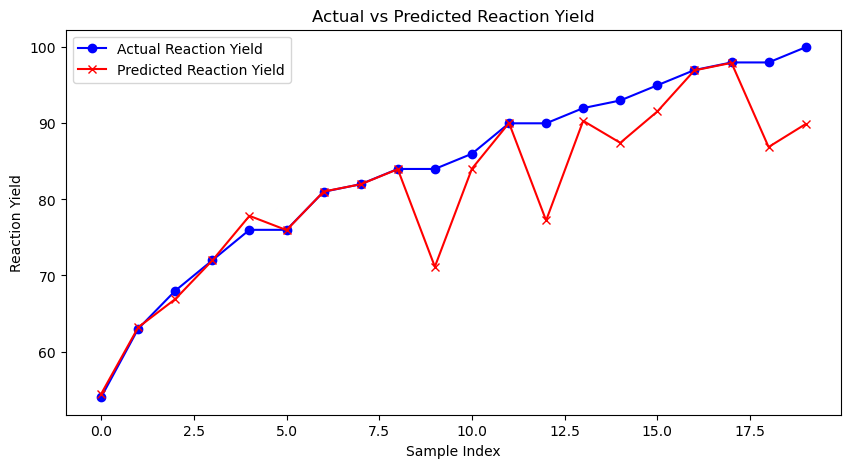

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume y_test contains the actual values and y_pred contains the predicted values

# Pair the y_test and y_pred values together and sort by y_test
sorted_pairs = sorted(zip(y_test, y_pred_loaded), key=lambda pair: pair[0])
y_test_sorted, y_pred_sorted = zip(*sorted_pairs)

# Convert sorted pairs to numpy arrays for plotting (if needed)
y_test_sorted = np.array(y_test_sorted)
y_pred_sorted = np.array(y_pred_sorted)

# Set up the plotting area
plt.figure(figsize=(10, 5))

# Line Plot of Actual vs Predicted
#plt.plot(y_test.values, label='Actual Reaction Yield', color='blue', marker='o')
#plt.plot(y_pred, label='Predicted Reaction Yield', color='red', marker='x')

plt.plot(y_test_sorted, label='Actual Reaction Yield', color='blue', marker='o')
plt.plot(y_pred_sorted, label='Predicted Reaction Yield', color='red', marker='x')

# Add title and labels
plt.title('Actual vs Predicted Reaction Yield')
plt.xlabel('Sample Index')
plt.ylabel('Reaction Yield')

# Add a legend
plt.legend()

# Save the plot to a file
#plt.savefig('actualvspredicted_yield_RLGB_TrainD112_Test20_80R2.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [13]:
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_loaded
})
results_df

,Actual,Predicted
0,98,97.944868
1,90,90.043754
2,72,71.981538
3,76,77.836285
4,100,89.904756
5,68,66.903042
6,84,83.967908
7,92,90.326130
8,82,81.986705
9,63,63.183840


## Scatter Plot

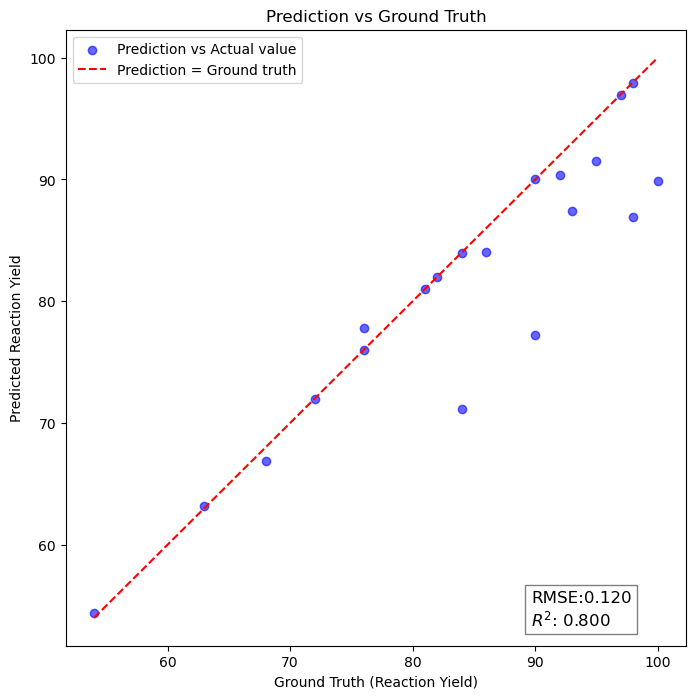

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Assume y_test contains the actual values and y_pred_loaded contains the predicted values

# Calculate performance metrics
#mse = mean_squared_error(y_test, y_pred_loaded)
#rmse = np.sqrt(mse)
#r2 = r2_score(y_test, y_pred_loaded)

# Set up the plotting area
plt.figure(figsize=(8, 8))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred_loaded, color='blue', label='Prediction vs Actual value', alpha=0.6)

# Plot a diagonal line representing perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Prediction = Ground truth')

# Add labels and title
plt.title('Prediction vs Ground Truth')
plt.xlabel('Ground Truth (Reaction Yield)')
plt.ylabel('Predicted Reaction Yield')

# Add a legend
plt.legend(loc='upper left')

# # Add the metrics as text in the plot
# plt.text(0.05, 0.95, f'MSE: {mse_loaded:.3f}\nRMSE:{rmse:.3f}\n$R^2$: {r2_loaded:.3f}', 
#          transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Add the metrics as text in the plot
plt.text(0.75, 0.09, f'RMSE:{rmse:.3f}\n$R^2$: {r2_loaded:.3f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))


# Save the plot (if needed)
#plt.savefig('actualvspredicted_yield_RLGB_TrainD112_Test20_80R2_ScatterPlot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
